# 3-qubit GHZ-state distillation protocol with pretrained local unitary operators

## Notebook description:

Author: Aron Rozgonyi - rozgonyi.aron@wigner.hu

Related article: https://doi.org/10.1016/j.physleta.2024.129349

In this notebook:
* Simulate a 3-qubit entangled state distillation protocol using pre-trained unitary operators.
* The initial state is a noisy (mixed) GHZ state - 2 copies: an original and an identical copy called "flag qubits".
* 3 parties: A,B,C each has 1-1 qubits from original and flag qubit sets
* Each party performs the same local operations U_t and |0X0| projections.
* The protocol is iterated to enhance the magnitude of entanglement.

Code blocks:
* defining projector matrices to be used as qubit measurement in |0X0| basis.
* creating initial density matrix of 2 identical noisy-GHZ states;		basis: |q1,q2,q3> x |q4,q5,q6>
* basis transformation to re-ordered basis |q1, q4, q2, q5, q3, q6> becasue U acts on (q1, q4), (q2, q5) and (q3, q6) qubit pairs.
* defining qubit tracing-out function as the protocol emits the projected (measured) flag qubits (q3, q4, q5).
* defining the iterative protocol function.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sy
import functools as ft
from itertools import product
from numpy.linalg import multi_dot
from scipy.sparse import csr_matrix
#from scipy.sparse import identity
from google.colab import files

%matplotlib inline

In [33]:
# Define Pauli matrix sigma_0
sigma_0 = np.array([[1, 0], [0, 1]])

# Define |0X0| measurement matrix
M0 = np.outer([1, 0], np.conjugate([1, 0]))

# Define |1X1| measurement matrix
M1 = np.outer([0, 1], np.conjugate([0, 1]))

def make_measurement_matrix(N, mea='0'):
  # N Number of parties
  # nq Number of qubits
  # mea desired measurement result on ancillary qubits -> possible inputs: 0/1; default mea='0'
  nq = 2*N
  if mea=='0':
    matrices = [sigma_0 if i % 2 == 0 else M0 for i in range(nq)]
    result = ft.reduce(np.kron, matrices)
  elif mea=='1':
    matrices = [sigma_0 if i % 2 == 0 else M1 for i in range(nq)]
    result = ft.reduce(np.kron, matrices)
  return result

In [35]:
S0 = np.array([1, 0])
S1 = np.array([0, 1])

def make_GHZ(nq):
  # nq Number of qubits
  listS0 = [S0 for _ in range(nq)]
  listS1 = [S1 for _ in range(nq)]
  GHZ = ft.reduce(np.kron, listS0).flatten()/ np.sqrt(2) + ft.reduce(np.kron, listS1).flatten() / np.sqrt(2)
  return GHZ

def make_rho_GHZ(rho):
  ''' Compute the outer product of GHZ and its conjugate'''
  return np.outer(rho, np.conjugate(rho))

# Convert the rho_GHZ to a sparse matrix
# rho_GHZ_sparse = csr_matrix(rho_GHZ)

def make_noisy_rho(rho_GHZ, nq, lambda_val):
  ''' Calculate noisy initial density matrix'''
  # lambda_val noise strength
  d = 2**nq # dimension
  rho_noisy = (1 - lambda_val) * rho_GHZ + lambda_val / d * np.identity(d)
  return rho_noisy

In [34]:
N = 3 # No. parties
nq = 2*N # No. qubits
basis = list(product([0, 1], repeat=nq))
basisS = ['|' + ''.join(map(str, b)) + '⟩' for b in basis]

def SWAP(i, j):
    ''' swapping arbitrary qubit_i and qubit_j '''
    def calc_index(k):
        if (k // 2**(nq - i)) % 2 == (k // 2**(nq - j)) % 2:
            return k
        else:
            return k ^ (2**(nq - i)) ^ (2**(nq - j))
    matrix = np.zeros((2**nq, 2**nq))
    for k in range(2**nq):
        matrix[k, calc_index(k)] = 1
    return matrix

# basis transformation
TRF = multi_dot([SWAP(3, 4), SWAP(3, 5), SWAP(2, 4)]) #N=3

In [38]:
#traceing out the ancillary qubits
def partial_trace(rho, N):
  ''' partial trace of rho(2^2n_x_2^2n), qubits: q0,q1,q2,q3,q4,q5,...qn-1
      tracing out even-numbered qubits, resulting in rho(2^n_x_2^n)
  '''
  # N number of ancillary qubit
  rho_traced = rho.reshape([2 for _ in range(2*2*N)])
  for i in range(N):
    rho_traced = np.trace(rho_traced, axis1=i+1, axis2=2*N+1)
  return rho_traced.reshape([2**N, 2**N])

In [39]:
# Unitary matrix constructed in previous notebook
matrix_Ut = np.array([[1/np.sqrt(2) * np.exp(1j * np.pi / 6), 0, 0, 1/np.sqrt(2) * 1j],
                   [0, 1/np.sqrt(2), 1/np.sqrt(2), 0],
                   [1/np.sqrt(2) * 1j, 0, 0, 1/np.sqrt(2) * np.exp(-1j * np.pi / 6)],
                   [0, 1/np.sqrt(2), -1/np.sqrt(2), 0]])

def make_operation_U(U, N):
  # N Number of parties
  matrix = U
  for i in range(N-1):
    matrix = np.kron(U, matrix)
  return matrix

In [40]:
def prot_rho(rho0, U, N, mea):
        # N number of ancillary qubit/ no. parties
        # Initial density matrix |GHZ>x|GHZ_copy>
        rho = np.kron(rho0, rho0)

        # Compute density matrix evolution according to the protocol
        left = multi_dot([make_measurement_matrix(N, mea), make_operation_U(U, N), TRF])
        right = np.matrix.getH(multi_dot([make_measurement_matrix(N, mea), make_operation_U(U, N), TRF]))
        rho_prime = multi_dot([left, rho, right])

        # Return with traced-out density matrix
        return partial_trace(rho_prime, N)

# Define the scheme_Rho function
def scheme_rho(rho0, U, N, n):
    ''' Apply prot_rho recursively n times '''
    result = rho0
    for i in range(n):
         result = prot_rho(result, U, N, '0')
         result = result / np.trace(result) # Normalize
    return result

# Define fidelity function
def fidelity(our_state, target):
  return multi_dot([np.conjugate(target), our_state, target])

In [43]:
noq = 3 #No. party
lam = 0.05 #Noise strength
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)
rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)

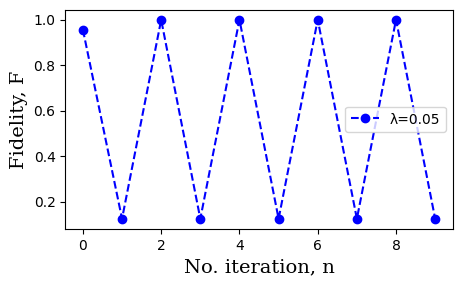

In [45]:
iter_data = list(range(10))
fid_data = [fidelity(scheme_rho(rho_noisy, matrix_Ut, noq, i), GHZ) for i in range(10)]

xfont = {'fontname':'serif'}

f = plt.figure(figsize=(5,3))
plt.plot(iter_data[0::1], fid_data[0::1], 'o--b', label='λ=0.05')
plt.xlabel('No. iteration, n', **xfont)
plt.ylabel('Fidelity, F', **xfont)
#plt.title('Noisy GHZ')
plt.legend()
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#plt.savefig('uniform-iter.pdf')
#files.download("uniform-iter.pdf")
plt.show()

In [50]:
noq = 3 #No. party
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)

noi = 10 #No. iteration
iter_data = list(range(noi))

list_of_fidelity = []
for l in [0.1, 0.3, 0.5, 0.7, 0.9]:
  fid_data = [fidelity(scheme_rho(make_noisy_rho(rho_GHZ, noq, l), matrix_Ut, noq, i), GHZ) for i in range(noi)]
  list_of_fidelity  += [fid_data]


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


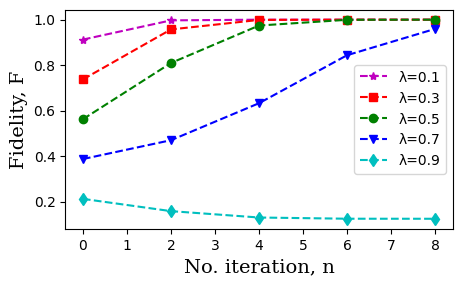

In [53]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data[0::2], list_of_fidelity[0][0::2], '*--m', label='λ=0.1')
ax.plot(iter_data[0::2], list_of_fidelity[1][0::2], 's--r', label='λ=0.3')
ax.plot(iter_data[0::2], list_of_fidelity[2][0::2], 'o--g', label='λ=0.5')
ax.plot(iter_data[0::2], list_of_fidelity[3][0::2], 'v--b', label='λ=0.7')
ax.plot(iter_data[0::2], list_of_fidelity[4][0::2], 'd--c', label='λ=0.9')
ax.legend()
ax.set_xlabel('No. iteration, n', **xfont)
ax.set_ylabel('Fidelity, F', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#fig.savefig('uniλ.pdf')
#files.download("uniλ.pdf")
plt.show()